# 一点信号处理迅速揭示了扩散模型和自回归模型并没有那么不同：**图像的扩散模型在频域中执行近似自回归！**

 *这个colab也以普通博客文章的形式在[我的网站sander.ai上](https://sander.ai/2024/09/02/spectral-autoregression.html)提供。*
 
 去年，我写了一篇博客文章描述了[扩散的各种不同视角](https://sander.ai/2023/07/20/perspectives.html)。这个想法是为了强调扩散模型与其他类别的模型和概念之间的多种联系。在最近几个月里，我做了几次演讲，讨论了其中一些视角。我在塞尔维亚诺维萨德[EEML 2024夏季学校](https://www.eeml.eu/)的演讲被录制下来，并[在YouTube上提供](https://www.youtube.com/watch?v=9BHQvQlsVdE)。根据我从这次演讲中得到的反馈，扩散模型与**自回归模型**之间的联系似乎特别引人深思。这就是为什么我认为进一步探索这一点可能会有用。
 
 在这篇博客文章中，我将解析上述主张，并尝试使其变得明显，至少对于视觉数据而言是如此。为了使事情更加具体，我决定以Python笔记本的形式（使用Google Colab）编写整个博客文章。这样，**你可以轻松地自己复现这些图表和分析**，并修改它们以观察会发生什么。我希望这种格式也能帮助传达这一点：扩散模型和自回归模型之间的联系是"真实的"，而不仅仅是一种在实践中站不住脚的理论理想化。
 
 在接下来的内容中，我将假设你对扩散模型及其背后的核心概念有基本的了解。如果你看过我上面链接的演讲，你应该能够跟上。或者，[扩散的视角](https://sander.ai/2023/07/20/perspectives.html)博客文章也应该足够作为预备阅读。对傅里叶变换的一些了解也会有所帮助。


# Imports and setup

In [ ]:
!pip install pysteps  
# 用于计算径向平均功率谱密度（RAPSDs）。

In [ ]:
!pip install deeplake[audio]  
# 需要加载GTZAN音乐/语音数据集。
# 虽然这个数据集被列为TensorFlow数据集的一部分，但该版本目前下载失败。
# 安装这个似乎会用不同版本替换pillow，这需要重新初始化运行时。有点不方便！

In [8]:
import itertools

In [9]:
import numpy as np
import scipy.interpolate
import cv2

In [10]:
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.pyplot as plt
from matplotlib import animation

In [11]:
from IPython.display import Audio, display

In [12]:
#import tensorflow_datasets as tfds
import deeplake
import librosa
from pysteps.utils import spectral

Pysteps configuration file found at: e:\conda_data\envs\heavy_daily\lib\site-packages\pysteps\pystepsrc



In [13]:
import requests

class Tweet(object):
    def __init__(self, s, embed_str=False):
        if not embed_str:
            # Use Twitter's oEmbed API
            # https://dev.twitter.com/web/embedded-tweets
            api = 'https://publish.twitter.com/oembed?url={}'.format(s)
            response = requests.get(api)
            self.text = response.json()["html"]
        else:
            self.text = s

    def _repr_html_(self):
        return self.text

#  迭代细化的两种形式
 
 自回归和扩散目前是两种主导的生成建模范式。还有许多其他构建生成模型的方法：[基于流的模型](https://en.wikipedia.org/wiki/Flow-based_generative_model)和[对抗性模型](https://en.wikipedia.org/wiki/Generative_adversarial_network)只是两种可能的替代方案（我在[之前的博客文章](https://sander.ai/2020/03/24/audio-generation.html#generative-models)中讨论了更多方法）。
 
 自回归和扩散与大多数这些替代方案的不同之处在于，它们将从复杂分布生成数据的困难任务分解为更容易学习的小子任务。自回归通过将要建模的数据转换为序列的形式，并递归地一次预测一个序列元素来实现这一点。而扩散则通过定义一个逐渐破坏数据中所有结构的腐蚀过程，并训练模型学习逐步逆转这一过程。
 
 这种**迭代细化**的生成建模方法非常强大，因为它允许我们构建非常深的生成计算图，而无需在训练期间通过它们进行反向传播。实际上，自回归模型和扩散模型都学习一次执行一个细化步骤——生成过程不是端到端训练的。只有当我们尝试从模型中采样时，我们才会通过顺序执行子任务来连接所有这些步骤：在自回归的情况下是一个接一个地预测序列元素，或者在扩散的情况下是逐步去噪输入。

 由于这种底层迭代方法是两种范式共有的，人们经常寻求将两者联系起来。例如，可以将自回归视为离散扩散的一种特殊情况，其腐蚀过程是从右到左逐渐用"掩码标记"替换标记，最终得到一个完全掩码的序列。在接下来的几节中，我们将做相反的事情，将扩散视为自回归的一种特殊情况，尽管是近似的。
 
 如今，大多数语言模型是自回归的，而大多数图像和视频模型则基于扩散。在许多其他应用领域（例如蛋白质设计、强化学习中的规划等），扩散模型也变得越来越普遍。我认为这种二分法，可以概括为"语言使用自回归，其他一切使用扩散"，非常有趣。我[之前写过关于这个话题](https://sander.ai/2023/01/09/diffusion-language.html)，并将在本文后面的部分中进一步讨论。


# 扩散的频谱视角
 
## 图像频谱
 
 当扩散模型在图像生成领域崭露头角时，人们很快注意到它们倾向于以从粗到细的方式生成图像。图像中的大尺度结构似乎在早期去噪步骤中就已确定，而后续的去噪步骤则逐渐添加更多细粒度的细节。

 为了形式化这一观察，我们可以使用信号处理，更具体地说是**频谱分析**。通过将图像分解为其组成的**空间频率**成分，我们可以更精确地区分其粗粒度和细粒度结构，它们分别对应于低频和高频。
 
 我们可以使用二维[傅里叶变换](https://en.wikipedia.org/wiki/Fourier_transform)来获取图像的频率表示。这种表示是可逆的，即它包含与像素表示相同的信息——只是以不同的方式组织。与像素表示类似，它是一个二维网格结构对象，具有与原始图像相同的宽度和高度，但坐标轴现在对应的是水平和垂直空间频率，而不是空间位置。
 
 为了看看这是什么样子，让我们取一些图像并可视化它们的频谱。

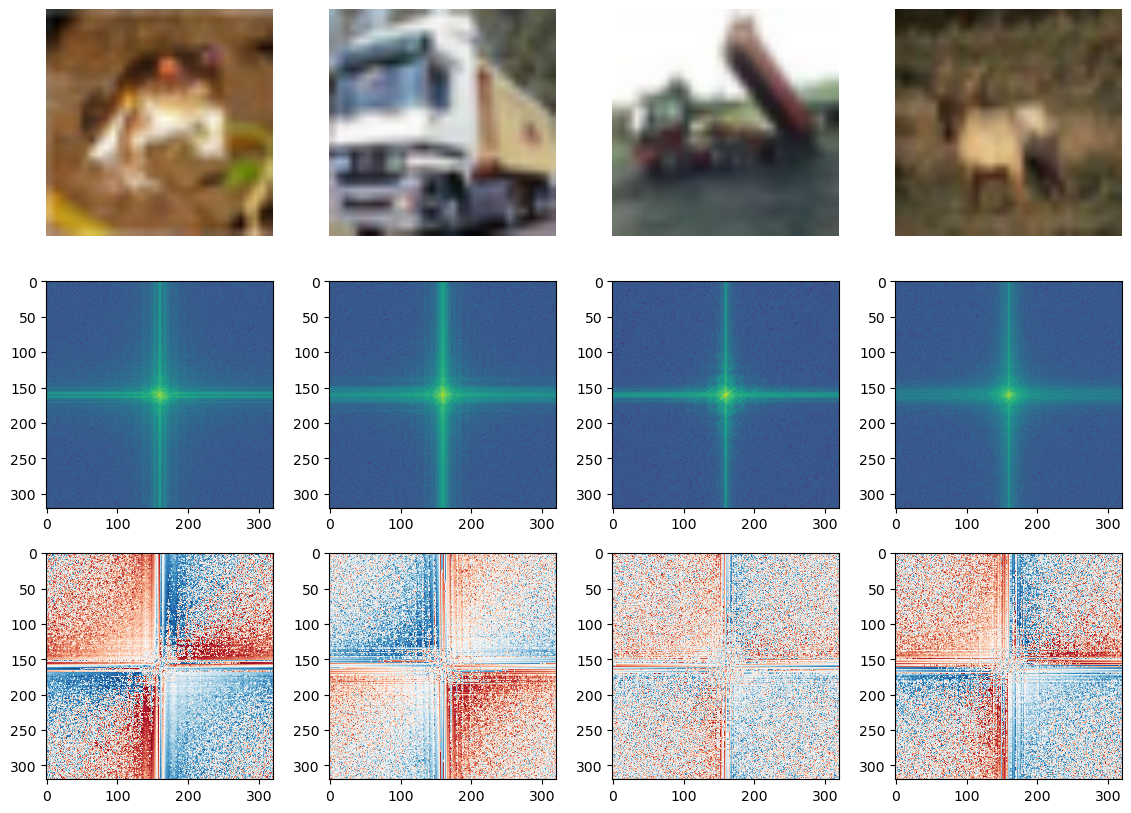

In [15]:
# 使用本地CIFAR-10数据集
import pickle
import os
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 加载CIFAR-10数据集
cifar10_dir = r"G:\code\datasets\cifar-10-batches-py"
images = []

# 加载训练数据
for i in range(1, 6):
    batch_file = os.path.join(cifar10_dir, f'data_batch_{i}')
    batch_data = unpickle(batch_file)
    batch_images = batch_data[b'data']
    batch_images = batch_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    images.append(batch_images)

# 合并所有批次
images = np.concatenate(images, axis=0)

# 只取前256张图像
num_examples = 256
images = images[:num_examples]

# 调整图像大小到320x320
def resize_and_crop(image, smallest_side):
    import cv2
    height, width, num_channels = image.shape

    # 调整大小
    if height <= width:
        new_height = smallest_side
        new_width = int(width * (new_height / height))
    else:
        new_width = smallest_side
        new_height = int(height * (new_width / width))

    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # 中心裁剪
    offset_h = (new_height - smallest_side) // 2
    offset_w = (new_width - smallest_side) // 2

    return image[offset_h:offset_h + smallest_side, offset_w:offset_w + smallest_side, :]

image_size = 320
resized_images = []
for img in images:
    resized_img = resize_and_crop(img, image_size)
    resized_images.append(resized_img)
images = np.array(resized_images)
images = (images.astype(np.float32) / 255.0) * 2 - 1  # 缩放并移动到[-1, 1]范围

num_displayed_examples = 4

plt.figure(figsize=(14, 10))

for k in range(num_displayed_examples):
    plt.subplot(3, 4, k + 1)
    plt.imshow((images[k] + 1) / 2)
    plt.axis('off')

for k in range(num_displayed_examples):
    spec = np.fft.fft2(images[k, ..., 1])
    spec = np.fft.fftshift(spec)
    plt.subplot(3, 4, 4 + k + 1)
    plt.imshow(np.log(np.abs(spec)), vmin=-5, vmax=11, cmap=plt.cm.viridis)
    plt.subplot(3, 4, 8 + k + 1)
    plt.imshow(np.angle(spec), vmin=-np.pi, vmax=np.pi, cmap=plt.cm.RdBu)

 上面第一行显示的是来自[Imagenette数据集](https://github.com/fastai/imagenette)的四张图像，这是ImageNet数据集的一个子集（我选择它是因为它加载相对较快）。

 傅里叶变换通常是复值的，所以接下来的两行分别可视化了频谱的_幅度_和_相位_。由于幅度在不同频率上变化很大，所以显示的是其对数值。相位是一个角度，在$-\pi$和$\pi$之间变化。请注意，我们只计算了绿色通道的频谱——我们也可以计算其他两个通道的频谱，但它们看起来会非常相似。（请记住，这是一个笔记本，如果你不相信我，可以自己尝试一下！）
 
 频谱的中心对应于最低的空间频率，随着我们向边缘移动，频率会增加。这使我们能够看到输入信号中的能量主要集中在哪里。请注意，默认情况下，情况恰恰相反（低频在角落，高频在中间），但`np.fft.fftshift`允许我们交换这些位置，从而产生一个更好看的可视化效果，使频谱的结构更加明显。
 
 关于自然图像的相位结构可以说很多有趣的事情，但在接下来的内容中，我们将主要关注幅度频谱。幅度的平方是_功率_，所以在实践中我们经常看的是_功率谱_。请注意，功率谱的对数就是幅度谱的对数乘以二。
 
 通过观察频谱，我们现在有了一种更正式的方法来推理图像中的不同特征尺度，但这仍然不能解释为什么扩散模型表现出这种从粗到细的行为。要了解为什么会发生这种情况，我们需要研究典型图像频谱的样子。为此，我们将**抽象二维空间中频率的方向性**，只需沿某个角度切片频谱，将该切片旋转一周，然后对所有旋转的切片取平均值。这会产生一条一维曲线：**径向平均功率谱密度，或RAPSD**。
 
 下面是一个动画，展示了2D频谱在对数-对数图上的各个方向切片，这些切片被平均以获得RAPSD。


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

spec = np.fft.fft2(images[3, ..., 1])
spec = np.fft.fftshift(spec)
ax1.imshow(np.log(np.abs(spec)), vmin=-5, vmax=11, cmap=plt.cm.viridis)

num_slices = 60
num_interp_points = 100
cycles_per_sec = 0.5

artists = []
for i in range(num_slices):
  angle = i * (2 * np.pi / num_slices)
  x = np.cos(angle)
  y = np.sin(angle)
  x_start = 1 / 2 * spec.shape[0]
  y_start = 1 / 2 * spec.shape[0]
  x_end = (x + 1) / 2 * spec.shape[0]
  y_end = (y + 1) / 2 * spec.shape[0]

  container = ax1.plot((x_start, x_end), (y_start, y_end), c='red', marker='o', markersize=3)  # This returns a list.

  interp = scipy.interpolate.RegularGridInterpolator(
      (np.arange(spec.shape[0]), np.arange(spec.shape[0])), np.abs(spec) ** 2 / spec.size)
  # NOTE: squaring + scaling the spectrum is done merely to match pysteps.utils.spectral.rapsd.
  x_line = np.linspace(x_start, x_end, num_interp_points, endpoint=False)
  y_line = np.linspace(y_start, y_end, num_interp_points, endpoint=False)
  coords_line = np.array([x_line, y_line]).T
  spec_line = interp(coords_line)
  container += ax2.plot(spec_line, c='red')  # Extend the list.

  artists.append(container)

ax1.set_ylim(0, spec.shape[0])
ax1.set_xlim(0, spec.shape[0])
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('frequency')
ax2.set_ylabel('power')

plt.close()  # Avoid showing static plot, we only want to see the animation.

anim = animation.ArtistAnimation(fig=fig, artists=artists, interval=1000 / (num_slices * cycles_per_sec))
anim

In [ ]:
# Uncomment the following to download the animation as a gif.
# writer = animation.PillowWriter()
# anim.save('image_spectrum.gif')
# files.download('image_spectrum.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's see what that looks like for the four images above. We will use the `pysteps` library, which comes with a handy function to calculate the RAPSD in one go.


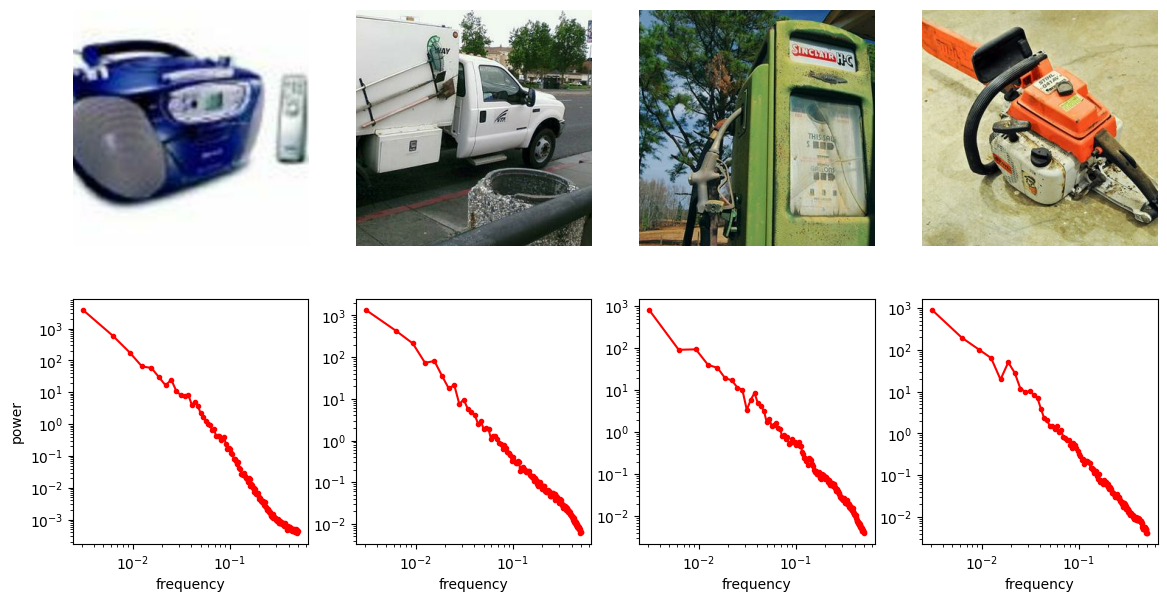

In [ ]:
plt.figure(figsize=(14, 7))
for k in range(num_displayed_examples):
  plt.subplot(2, 4, k + 1)
  plt.imshow((images[k] + 1) / 2)
  plt.axis('off')

for k in range(num_displayed_examples):
  rapsd, frequencies = spectral.rapsd(images[k, ..., 1], fft_method=np.fft, return_freq=True)
  plt.subplot(2, 4, 4 + k + 1)
  plt.plot(frequencies[1:], rapsd[1:], c='red', marker='o', markersize=3)  # Chop off the DC component.
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('frequency')
  if k == 0:
    plt.ylabel('power')

The RAPSD is best visualised on a log-log plot, to account for the large variation in scale. We chop off the so-called DC component (with frequency 0) to avoid taking the logarithm of 0.

Another thing this visualisation makes apparent is that the curves are remarkably close to being straight lines. A straight line on a log-log plot implies that there might be a power law lurking behind all of this.

Indeed, this turns out to be the case: **natural image spectra tend to approximately follow a power law**, which means that the power $P(f)$ of a particular frequency $f$ is proportional to $f^{-\alpha}$, where $\alpha$ is a parameter ([van der Schaaf & van Hateren, 1996](https://www.sciencedirect.com/science/article/pii/0042698996000028), [Torralba & Oliva, 2003](https://web.mit.edu/torralba/www/ne3302.pdf), [Hyvärinen et al., 2009](https://dl.acm.org/doi/abs/10.5555/1572513)). In practice, $\alpha$ is often remarkably close to 2 (which corresponds to the spectrum of [pink noise](https://en.wikipedia.org/wiki/Pink_noise) in two dimensions).

We can get closer to the "typical" RAPSD by taking the average across a bunch of images (in the log-domain).

In [ ]:
def calc_mean_log_rapsd(x):
  spectra = []
  for k in range(num_examples):
    rapsd, frequencies = spectral.rapsd(x[k, ...], fft_method=np.fft, return_freq=True)
    spectra.append(rapsd)

  mean_log_rapsd = np.mean(np.array([np.log(s + 1e-30) for s in spectra]), axis=0)
  return mean_log_rapsd, frequencies

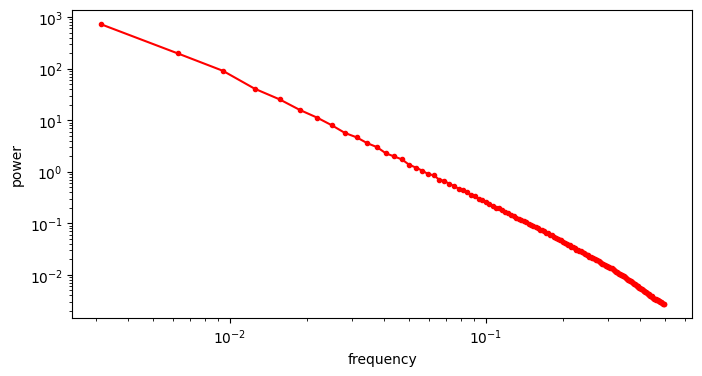

In [ ]:
mean_log_rapsd, frequencies = calc_mean_log_rapsd(images[..., 1])

plt.figure(figsize=(8, 4))
plt.plot(frequencies[1:], np.exp(mean_log_rapsd)[1:], c='red', marker='o', markersize=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('power');

As I'm sure you will agree, that is pretty unequivocally a power law!

To estimate the exponent $\alpha$, we can simply use linear regression in log-log space. Before proceeding however, it is useful to resample our averaged RAPSD so the sample points are linearly spaced in log-log space -- otherwise our fit will be dominated by the high frequencies, where we have many more sample points.



In [ ]:
log_frequencies = np.log(frequencies[1:])
equally_spaced_log_frequencies = np.linspace(log_frequencies[0], log_frequencies[-1], 1000)
interpolated_rapsd = np.interp(equally_spaced_log_frequencies, log_frequencies, mean_log_rapsd[1:])

m, b = np.polyfit(equally_spaced_log_frequencies, interpolated_rapsd, 1)
linear_fit = m * equally_spaced_log_frequencies + b

m

-2.4541858352451635

We obtain an estimate $\hat{\alpha} = 2.454$, which is a bit higher than the typical value of 2. As far as I understand, this can be explained by the presence of man-made objects in many of the images we used, because they tend to have smooth surfaces and straight angles, which results in comparatively more low-frequency content and less high-frequency content compared to images of nature. Let's see what our fit looks like.

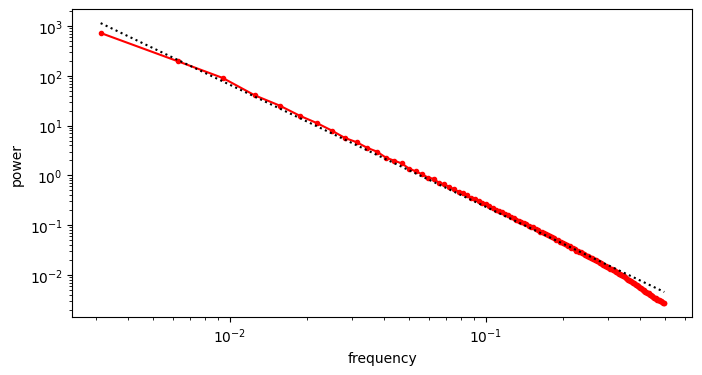

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(frequencies[1:], np.exp(mean_log_rapsd)[1:], c='red', marker='o', markersize=3)
plt.plot(np.exp(equally_spaced_log_frequencies), np.exp(linear_fit), linestyle='dotted', c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('power');

## Noisy image spectra

A crucial aspect of diffusion models is the corruption process, which involves adding Gaussian noise. Let's see what this does to the spectrum. The first question to ask is: what does the spectrum of noise look like? We can repeat the previous procedure, but replace the image input with standard Gaussian noise. For contrast, we will visualise the spectrum of the noise alongside that of the images from before.



In [ ]:
noise = np.random.normal(0, 1, size=images.shape)

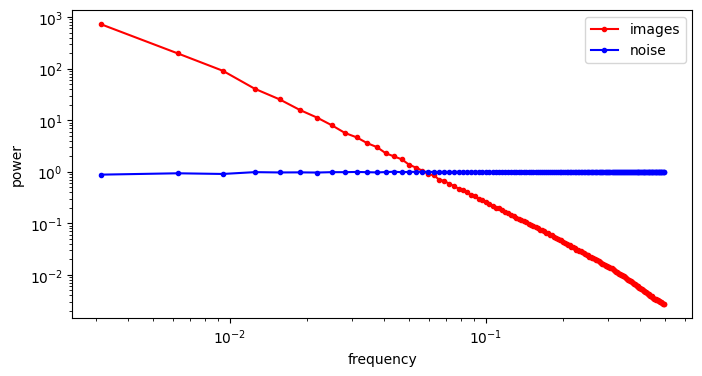

In [ ]:
mean_log_rapsd_noise, _ = calc_mean_log_rapsd(noise[..., 1])

plt.figure(figsize=(8, 4))
plt.plot(frequencies[1:], np.exp(mean_log_rapsd)[1:], c='red', marker='o', markersize=3, label='images')
plt.plot(frequencies[1:], np.exp(mean_log_rapsd_noise)[1:], c='blue', marker='o', markersize=3, label='noise')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('power')
plt.legend();

The RAPSD of Gaussian noise is also a straight line on a log-log plot; but a horizontal one, rather than one that slopes down. This reflects the fact that **Gaussian noise contains all frequencies in equal measure**. The Fourier transform of Gaussian noise is itself Gaussian noise, so its power must be equal across all frequencies in expectation.

When we add noise to the images and look at the spectrum of the resulting noisy images, we see a hinge shape:

In [ ]:
noisy_images = images + noise

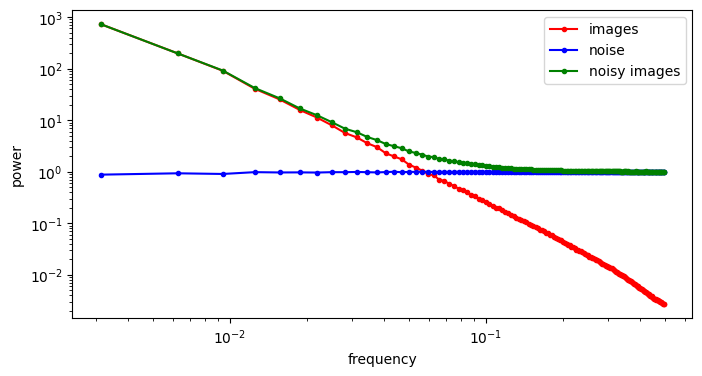

In [ ]:
mean_log_rapsd_sum, _ = calc_mean_log_rapsd(noisy_images[..., 1])

plt.figure(figsize=(8, 4))
plt.plot(frequencies[1:], np.exp(mean_log_rapsd)[1:], c='red', marker='o', markersize=3, label='images')
plt.plot(frequencies[1:], np.exp(mean_log_rapsd_noise)[1:], c='blue', marker='o', markersize=3, label='noise')
plt.plot(frequencies[1:], np.exp(mean_log_rapsd_sum)[1:], c='green', marker='o', markersize=3, label='noisy images')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('power')
plt.legend();

Why does this happen? Recall that the **Fourier transform is linear**: the Fourier transform of the sum of two things, is the sum of the Fourier transforms of those things. Because the power of the different frequencies varies across orders of magnitude, **one of the terms in this sum tends to drown out the other**. This is what happens at low frequencies, where the image spectrum dominates, and hence the green curve overlaps with the red curve. At high frequencies on the other hand, the noise spectrum dominates, and the green curve overlaps with the blue curve. In between, there is a transition zone where the power of both spectra is roughly matched.

If we increase the variance of the noise by scaling the noise term, we increase its power, and as a result, its RAPSD will shift upward (which is also a consequence of the linearity of the Fourier transform). This means a smaller part of the image spectrum now juts out above the waterline: **the increasing power of the noise looks like the rising tide!**

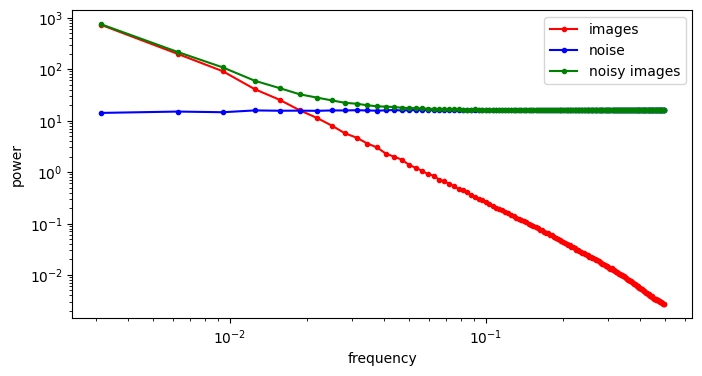

In [ ]:
high_noise = 4 * noise  # Increase the variance.
mean_log_rapsd_high_noise, _ = calc_mean_log_rapsd(high_noise[..., 1])

very_noisy_images = images + high_noise
mean_log_rapsd_high_noise_sum, _ = calc_mean_log_rapsd(very_noisy_images[..., 1])

plt.figure(figsize=(8, 4))
plt.plot(frequencies[1:], np.exp(mean_log_rapsd)[1:], c='red', marker='o', markersize=3, label='images')
plt.plot(frequencies[1:], np.exp(mean_log_rapsd_high_noise)[1:], c='blue', marker='o', markersize=3, label='noise')
plt.plot(frequencies[1:], np.exp(mean_log_rapsd_high_noise_sum)[1:], c='green', marker='o', markersize=3, label='noisy images')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('power')
plt.legend()



At this point, I'd like to revisit a diagram from the [perspectives on diffusion blog post](https://sander.ai/2023/07/20/perspectives.html#autoregressive), where I originally drew the connection between diffusion and autoregression in frequency space, which is shown below.

<img src="https://sander.ai/images/image_spectra.png">

These idealised plots of the spectra of images, noise, and their superposition match up pretty well with the real versions. When I originally drew this, I didn't actually realise just how closely this reflects reality!

What these plots reveal is an approximate equivalence (in expectation) between adding noise to images, and **low-pass filtering** them. The noise will drown out some portion of the high frequencies, and leave the low frequencies untouched. The variance of the noise determines the **cut-off frequency** of the filter. Note that this is the case only because of the characteristic shape of natural image spectra.

The animation below shows how the spectrum changes as we gradually add more noise, until it eventually overpowers all frequency components, and all image content is gone.



In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), width_ratios=[2, 1])

ax1.plot(frequencies[1:], np.exp(mean_log_rapsd)[1:], c='red', marker='o', markersize=3, label='images')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('frequency')
ax1.set_ylabel('power')
ax2.axis('off')

num_steps = 7
cycles_per_sec = 0.2
selected_image_idx = 1

noise_scale_min, noise_scale_max = 0.02, 50.0
noise_scales = np.logspace(np.log10(noise_scale_min), np.log10(noise_scale_max), num_steps)

artists = []
for i in range(num_steps):
  current_noise = noise_scales[i] * noise
  noisy_images = images + current_noise
  mean_log_rapsd_noise, _ = calc_mean_log_rapsd(current_noise[..., 1])
  mean_log_rapsd_sum, _ = calc_mean_log_rapsd(noisy_images[..., 1])
  container = ax1.plot(frequencies[1:], np.exp(mean_log_rapsd_noise)[1:], c='blue', marker='o', markersize=3, label='noise')
  container += ax1.plot(frequencies[1:], np.exp(mean_log_rapsd_sum)[1:], c='green', marker='o', markersize=3, label='noisy images')

  container += [ax2.imshow(np.clip((noisy_images[selected_image_idx] + 1) / 2, 0, 1))]

  artists.append(container)

plt.close()  # Avoid showing static plot, we only want to see the animation.

anim = animation.ArtistAnimation(fig=fig, artists=artists, interval=1000 / (num_steps * cycles_per_sec))
anim

In [ ]:
# Uncomment the following to download the animation as a gif.
# writer = animation.PillowWriter()
# anim.save('rising_tide.gif')
# files.download('rising_tide.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## Diffusion

With this in mind, it becomes apparent that the corruption process used in diffusion models is actually gradually filtering out more and more high-frequency information from the input image, and the different time steps of the process correspond to a frequency decomposition: basically an approximate version of the **Fourier transform**!

Since diffusion models themselves are tasked with reversing this corruption process step-by-step, they end up roughly predicting the next higher frequency component at each step of the generative process, given all preceding (lower) frequency components. This is a soft version of **autoregression in frequency space**, or if you want to make it sound fancier, **approximate spectral autoregression**.

To the best of my knowledge, [Rissanen et al. (2022)](https://arxiv.org/abs/2206.13397) were the first to apply this kind of analysis to diffusion in the context of generative modelling (see §2.2 in the paper). Their work directly inspired this blog post.

In many popular formulations of diffusion, the corruption process does not just involve adding noise, but also rescaling the input to keep the total variance within a reasonable range (or constant, in the case of variance-preserving diffusion). I have largely ignored this so far, because it doesn't materially change anything about the intuitive interpretation. Scaling the input simply results in the RAPSD shifting up or down a bit.



## Which frequencies are modelled at which noise levels?

There seems to be a monotonic relationship between noise levels and spatial frequencies (and hence feature scales). Can we characterise this quantitatively?

We can try, but it is important to emphasise that this relationship is only really valid in expectation, averaged across many images: **for individual images, the spectrum will not be a perfectly straight line, and it will not typically be monotonically decreasing**.

Even if we ignore all that, the "elbow" of the hinge-shaped spectrum of a noisy image is not very sharp, so it is clear that there is quite a large transition zone where we cannot unequivocally say that a particular frequency is dominated by either signal or noise. So this is, at best, a very smooth approximation to the "hard" autoregression used in e.g. large language models.

Keeping all of that in mind, let us construct a mapping from noise levels to frequencies for a particular diffusion process and a particular image distribution, by choosing a signal-to-noise ratio (SNR) threshold, below which we will consider the signal to be undetectable. This choice is quite arbitrary, and we will just have to choose a value and stick with it. We can choose 1 to keep things simple, which means that we consider the signal to be detectable if its power is equal to or greater than the power of the noise.

Consider a Gaussian diffusion process for which $\mathbf{x}_t = \alpha(t)\mathbf{x}_0 + \sigma(t) \mathbf{\varepsilon}$, with $\mathbf{x}_0$ an example from the data distribution, and $\mathbf{\varepsilon}$ standard Gaussian noise.

Let us define $\mathcal{R}[\mathbf{x}](f)$ as the RAPSD of an image $\mathbf{x}$ evaluated at frequency $f$. We will call the SNR threshold $\tau$. If we consider a particular time step $t$, then assuming the RAPSD is monotonically decreasing, we can define the **maximal detectable frequency** $f_\max$ at this time step in the process as the maximal value of $f$ for which:

$$ \mathcal{R}[\alpha(t)\mathbf{x}_0](f) > \tau \cdot \mathcal{R}[\sigma(t)\mathbf{\varepsilon}](f). $$

Recall that the Fourier transform is a linear operator, and $\mathcal{R}$ is a radial average of the square of its magnitude. Therefore, scaling the input to $\mathcal{R}$ by a real value means the output gets scaled by its square. We can use this to simplify things:

$$ \mathcal{R}[\mathbf{x}_0](f) > \tau \cdot \frac{\sigma(t)^2}{\alpha(t)^2} \mathcal{R}[\mathbf{\varepsilon}](f). $$

We can further simplify this by noting that $\forall f: \mathcal{R}[\mathbf{\varepsilon}](f) = 1$:

$$ \mathcal{R}[\mathbf{x}_0](f) > \tau \cdot \frac{\sigma(t)^2}{\alpha(t)^2}. $$

To construct such a mapping in practice, we first have to choose a diffusion process, which gives us the functional form of $\sigma(t)$ and $\alpha(t)$. To keep things simple, we can use the rectified flow / flow matching process ([Liu et al., 2022](https://arxiv.org/abs/2209.03003), [Lipman et al., 2022](https://arxiv.org/abs/2210.02747)), as used in Stable Diffusion 3 ([Esser et al., 2024](https://arxiv.org/abs/2403.03206)), for which $\sigma(t) = t$ and $\alpha(t) = 1 - t$. Combined with $\tau = 1$, this yields:

$$ \mathcal{R}[\mathbf{x}_0](f) > \left(\frac{t}{1 - t}\right)^2. $$

With these choices, we can now determine the shape of $f_\max(t)$ and visualise it.


In [ ]:
timesteps = np.linspace(0, 1, 100)
snr_threshold = 1.0
min_power = snr_threshold * (timesteps / (1 - timesteps)) ** 2

comparison = np.exp(mean_log_rapsd)[:, np.newaxis] > min_power[np.newaxis, :]

# find the first frequency whose power is above the threshold, going from high to low frequencies.
reverse_indices = np.argmax(comparison[::-1], axis=0)
max_frequencies = frequencies[::-1][reverse_indices]

# Above a certain noise level, none of the frequencies are detectable, so np.argmax will do the wrong thing.
# We should mask those out and set them to zero.
mask = np.any(comparison, axis=0)
max_frequencies *= mask

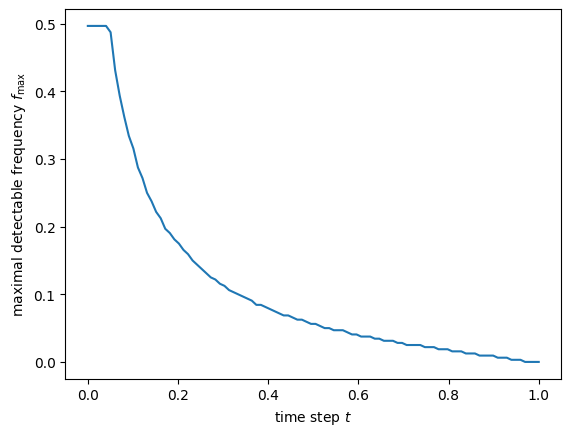

In [ ]:
plt.plot(timesteps, max_frequencies)
plt.xlabel('time step $t$')
plt.ylabel('maximal detectable frequency $f_\max$');

The frequencies here are relative: if the bandwidth of the signal is 1, then 0.5 corresponds to the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency), i.e. the maximal frequency that is representable with the given bandwidth.

Note that all representable frequencies are detectable at time steps near 0. As $t$ increases, so does the noise level, and hence $f_\max$ starts dropping, until it eventually reaches 0 (no detectable signal frequencies are left) close to $t = 1$.

# What about sound?

All of the analysis above hinges on the fact that spectra of natural images typically follow a power law. Diffusion models have also been used to generate audio ([Chen et al., 2020](https://arxiv.org/abs/2009.00713), [Kong et al., 2020](https://arxiv.org/abs/2009.09761)), which is the other main perceptual modality besides the visual. A very natural question to ask is whether the same interpretation makes sense in the audio domain as well.

To establish that, we will grab a dataset of typical audio recordings that we might want to build a generative model of: speech and music.





In [ ]:
import deeplake
ds = deeplake.load("hub://activeloop/gtzan-music-speech")

-

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-music-speech



/

hub://activeloop/gtzan-music-speech loaded successfully.



In [ ]:
def split_into_chunks(audio, length):
  num_chunks = audio.shape[0] // length
  audio = audio[:num_chunks * length]
  return np.reshape(audio, (num_chunks, length))

In [ ]:
num_examples = 128
sample_rate = 22050
audio_length = 2 * sample_rate  # 2 seconds.
sounds = []
for example in itertools.islice(ds.tensorflow(), num_examples):
  arr = example['audio'].numpy()[..., 0]  # Remove channel axis.
  arr = split_into_chunks(arr, audio_length)
  sounds.append(arr)
sounds = np.concatenate(sounds, axis=0)
num_clips = sounds.shape[0]

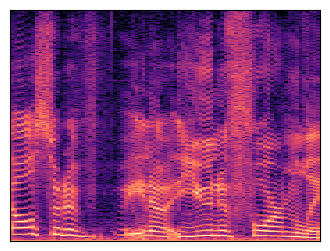

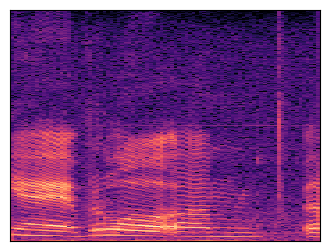

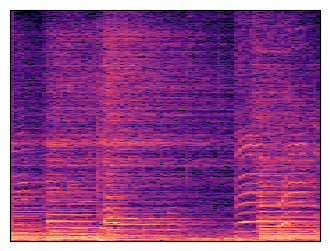

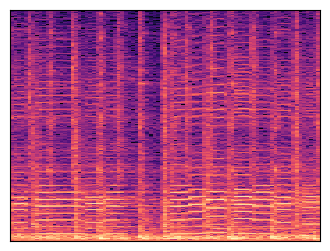

In [ ]:
displayed_examples = [0, 500, 1000, 1500]

for k in displayed_examples:
  display(Audio(data=sounds[k], rate=sample_rate))
  plt.figure(figsize=(4, 3))
  stft = librosa.stft(sounds[k], n_fft=1024, hop_length=512)
  spec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
  librosa.display.specshow(spec)
  plt.show()

Along with each audio player, a _spectrogram_ is shown: this is a time-frequency representation of the sound, which is obtained by applying the Fourier transform to short overlapping windows of the waveform and stacking the resulting magnitude vectors together in a 2D matrix.

For the purpose of comparing the spectrum of sound with that of images, we will use the 1-dimensional analogue of the RAPSD, which is simply the squared magnitude of the 1D Fourier transform.

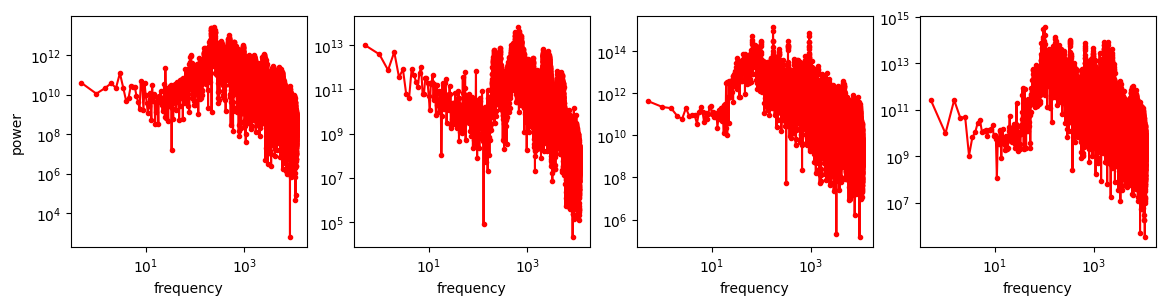

In [ ]:
plt.figure(figsize=(14, 3))

frequencies = np.fft.rfftfreq(audio_length, 1 / sample_rate)

for i, k in enumerate(displayed_examples):
  spec = abs(np.fft.rfft(sounds[k])) ** 2
  plt.subplot(1, 4, i + 1)
  plt.plot(frequencies[1:], spec[1:], c='red', marker='o', markersize=3)  # Chop off the DC component.
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('frequency')
  if k == 0:
    plt.ylabel('power')

These are a lot noisier than the image spectra, which is not surprising as these are not averaged over directions, like the RAPSD is. But aside from that, they don't really look like straight lines either -- the power law shape is nowhere to be seen!

I won't speculate about why images exhibit this behaviour and sound seemingly doesn't, but it is certainly interesting (feel free to speculate away in the comments!). To get a cleaner view, we can again average the spectra of many clips in the log domain, as we did with the RAPSDs of images.

In [ ]:
def calc_mean_log_spec(x):
  spectra = []
  for k in range(x.shape[0]):
    spec = abs(np.fft.rfft(x[k])) ** 2
    spectra.append(spec)

  mean_log_spec = np.mean(np.array([np.log(s + 1e-30) for s in spectra]), axis=0)
  return mean_log_spec

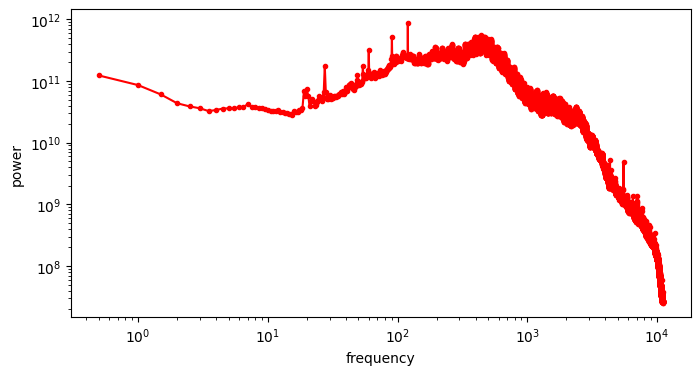

In [ ]:
mean_log_spec = calc_mean_log_spec(sounds)

plt.figure(figsize=(8, 4))
plt.plot(frequencies[1:], np.exp(mean_log_spec)[1:], c='red', marker='o', markersize=3)  # Chopping of the DC component with frequency 0.
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('power');

Definitely not a power law. More importantly, it is not monotonic, so adding progressively more Gaussian noise to this does not obfuscate frequencies in descending order: **the "diffusion is just spectral autoregression" meme does not apply to audio waveforms!**

The average spectrum of our dataset exhibits a peak around 300-400 Hz. This is not too far off the typical spectrum of [green noise](https://en.wikipedia.org/wiki/Colors_of_noise#Green_noise), which has more energy in the region of 500 Hz. Green noise is supposed to sound like "the background noise of the world".

In [ ]:
noise = np.random.normal(0, 1, size=sounds.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(frequencies[1:], np.exp(mean_log_spec)[1:], c='red', marker='o', markersize=3, label='sound clips')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency')
ax.set_ylabel('power')

num_steps = 7
cycles_per_sec = 0.2

# NOTE: noise scales are comparatively high because the sound waveforms are scaled between -2**15 and 2**15.
noise_scale_min, noise_scale_max = 1e1, 1e5
noise_scales = np.logspace(np.log10(noise_scale_min), np.log10(noise_scale_max), num_steps)

artists = []
for i in range(num_steps):
  current_noise = noise_scales[i] * noise
  noisy_sounds = sounds + current_noise
  mean_log_spec_noise = calc_mean_log_spec(current_noise)
  mean_log_spec_sum = calc_mean_log_spec(noisy_sounds)
  container = ax.plot(frequencies[1:], np.exp(mean_log_spec_noise)[1:], c='blue', marker='o', markersize=3, label='noise')
  container += ax.plot(frequencies[1:], np.exp(mean_log_spec_sum)[1:], c='green', marker='o', markersize=3, label='noisy sound clips')
  artists.append(container)

plt.close()  # Avoid showing static plot, we only want to see the animation.

anim = animation.ArtistAnimation(fig=fig, artists=artists, interval=1000 / (num_steps * cycles_per_sec))
anim

In [ ]:
# Uncomment the following to download the animation as a gif.
# writer = animation.PillowWriter()
# anim.save('rising_tide_sound.gif')
# files.download('rising_tide_sound.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As the animation above shows, the different frequencies present in audio signals still get filtered out gradually from least powerful to most powerful, because the spectrum of Gaussian noise is still flat, just like in the image domain. But as the audio spectrum does not monotonically decay with increasing frequency, the order is not monotonic in terms of the frequencies themselves.

What does this mean for diffusion in the waveform domain? That's not entirely clear to me. It certainly makes the link with autoregressive models weaker, but I'm not sure if there are any negative implications for generative modelling performance.

One observation that does perhaps indicate that this is the case, is that a lot of diffusion models of audio described in the literature **do not operate directly in the waveform domain**. It is quite common to first extract some form of spectrogram (as we did earlier), and perform diffusion in that space, essentially treating it like an image ([Hawthorne et al., 2022](https://arxiv.org/abs/2206.05408), [Forsgren & Martiros, 2022](https://en.wikipedia.org/wiki/Riffusion), [Zhu et al., 2023](https://arxiv.org/abs/2311.08667)). Note that spectrograms are a somewhat lossy representation of sound, because [phase information is typically discarded](https://sander.ai/2020/03/24/audio-generation.html#why-waveforms).

To understand the implications of this for diffusion models, we will extract **log-scaled mel-spectrograms** from the sound clips we have used before. The [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a nonlinear frequency scale which is intended to be perceptually uniform, and which is very commonly used in spectral analysis of sound.

Next, we will interpret these spectrograms as images and look at their spectra. Taking the spectrum of a spectrum might seem odd -- some of you might even suggest that it is pointless, because the Fourier transform is its own inverse! But note that there are a few nonlinear operations happening in between: taking the magnitude (discarding the phase information), mel-binning and log-scaling. As a result, this second Fourier transform doesn't just undo the first one.





In [ ]:
melspectrograms = [librosa.power_to_db(librosa.feature.melspectrogram(y=sounds[k], sr=sample_rate)) for k in range(len(sounds))]

In [ ]:
melspectrogram_spectra = [spectral.rapsd(melspectrograms[k], fft_method=np.fft) for k in range(len(melspectrograms))]
_, frequencies = spectral.rapsd(melspectrograms[0], fft_method=np.fft, return_freq=True)

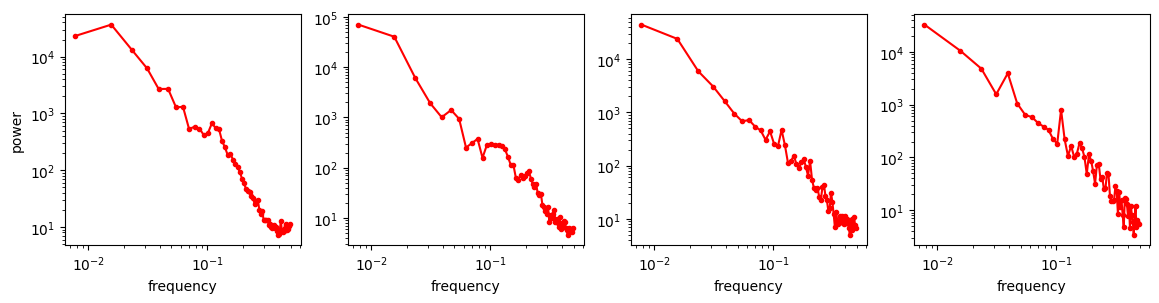

In [ ]:
plt.figure(figsize=(14, 3))

for i, k in enumerate(displayed_examples):
  plt.subplot(1, 4, i + 1)
  spec = melspectrogram_spectra[k]
  plt.plot(frequencies[1:], spec[1:], c='red', marker='o', markersize=3)  # Chop off the DC component.
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('frequency')
  if k == 0:
    plt.ylabel('power')

It seems like the power law has resurfaced! We can look at the average in the log-domain again to get a smoother curve.

In [ ]:
mean_log_melspectrogram_rapsd = np.mean(np.array([np.log(s + 1e-30) for s in melspectrogram_spectra]), axis=0)

In [ ]:
log_frequencies = np.log(frequencies[1:])
equally_spaced_log_frequencies = np.linspace(log_frequencies[0], log_frequencies[-1], 1000)
interpolated_rapsd = np.interp(equally_spaced_log_frequencies, log_frequencies, mean_log_melspectrogram_rapsd[1:])

m, b = np.polyfit(equally_spaced_log_frequencies, interpolated_rapsd, 1)
linear_fit = m * equally_spaced_log_frequencies + b

m

-2.3482236580960003

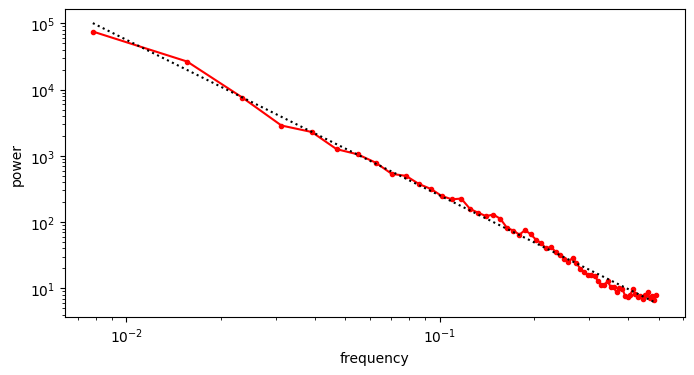

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(frequencies[1:], np.exp(mean_log_melspectrogram_rapsd)[1:], c='red', marker='o', markersize=3)  # Chopping of the DC component with frequency 0.
plt.plot(np.exp(equally_spaced_log_frequencies), np.exp(linear_fit), linestyle='dotted', c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('power');

I found this pretty surprising. I actually used to object quite strongly to the idea of treating spectrograms as images, as in this tweet in response to [Riffusion](https://en.wikipedia.org/wiki/Riffusion), a variant of Stable Diffusion finetuned on spectrograms:

In [ ]:
Tweet("https://twitter.com/sedielem/status/1603412454427574279")


... but I have always had to concede that it seems to work pretty well in practice, and perhaps the fact that spectrograms exhibit power-law spectra is one reason why.

There is also an interesting link with [mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), a popular feature representation for speech and music processing which predates the advent of deep learning. These features are constructed by taking the [discrete cosine transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) of a mel-spectrogram. The resulting spectrum-of-a-spectrum is often referred to as the **cepstrum**.

So with this approach, perhaps the meme applies to sound after all, albeit with a slight adjustment: **diffusion on spectrograms is just cepstral autoregression**.

# Unstable equilibrium

So far, we have talked about a spectral perspective on diffusion, but we have not really discussed how it can be used to explain why diffusion works so well for images. The fact that this interpretation is possible for images, but not for some other domains, does not automatically imply that the method should also work better.

However, it does mean that the diffusion loss, which is a weighted average across all noise levels, is also implicitly a weighted average over all spatial frequencies in the image domain. Being able to individually weight these frequencies in the loss according to their relative importance is key, because the sensitivity of the human visual system to particular frequencies varies greatly. **This effectively makes the diffusion training objective a kind of perceptual loss**, and I believe it largely explains the success of diffusion models in the visual domain (together with [classifier-free guidance](https://sander.ai/2023/08/28/geometry.html)).

Going beyond images, one could use the same line of reasoning to try and understand why diffusion models _haven't_ really caught on in the domain of language modelling so far (I wrote more about this [last year](https://sander.ai/2023/01/09/diffusion-language.html)). The interpretation in terms of a frequency decomposition is not really applicable there, and hence being able to change the relative weighting of noise levels in the loss doesn't quite have the same impact on the quality of generated outputs.

For language modelling, autoregression is currently the dominant modelling paradigm, and while diffusion-based approaches have been making inroads recently ([Lou et al. 2023](https://arxiv.org/abs/2310.16834), [Sahoo et al. 2024](https://arxiv.org/abs/2406.07524), [Shi et al. 2024](https://arxiv.org/abs/2406.04329)), a full-on takeover does not look like it is in the cards in the short term.

This results in the following status quo: **we use autoregression for language, and we use diffusion for pretty much everything else**. Of course, I realise that I have just been arguing that these two approaches are not all that different in spirit. But in practice, their implementations can look quite different, and a lot of knowledge and experience that practitioners have built up is specific to each paradigm.

To me, this feels like an **unstable equilibrium, because the future is multimodal**. We will ultimately want models that natively understand language, images, sound and other modalities mixed together. Grafting these two different modelling paradigms together to construct multimodal models is effective to some extent, and certainly interesting from a research perspective, but it brings with it an increased level of complexity (i.e. having to master two different modelling paradigms) which I don't believe practitioners will tolerate in the long run.

So in the longer term, it seems plausible that we could go back to using autoregression across all modalities, perhaps borrowing some ideas from diffusion in the process ([Tian et al. 2024](https://arxiv.org/abs/2404.02905), [Li et al. 2024](https://arxiv.org/abs/2406.11838)). Alternatively, we might figure out how to build multimodal diffusion models for all modalities, including language. I don't know which it is going to be, but both of those outcomes ultimately seem more likely than the current situation persisting.

One might ask, if diffusion is really just approximate autoregression in frequency space, why not just do exact autoregression in frequency space instead, and maybe that will work just as well? That would mean we can use autoregression across all modalities, and resolve the "instability" in one go. [Nash et al. (2021)](https://arxiv.org/abs/2103.03841), [Tian et al. (2024)](https://arxiv.org/abs/2404.02905) and [Mattar et al. (2024)](https://arxiv.org/abs/2406.19997) explore this direction.

There is a good reason not to take this shortcut, however: the diffusion sampling procedure is exceptionally flexible, in ways that autoregressive sampling is not. For example, the number of sampling steps can be chosen at test time (this isn't impossible for autoregressive models, but it is much less straightforward to achieve). This flexibility also enables [various distillation methods](https://sander.ai/2024/02/28/paradox.html) to reduce the number of steps required, and [classifier-free guidance](https://sander.ai/2023/08/28/geometry.html) to improve sample quality. Before we do anything rash and ditch diffusion altogether, we will probably want to figure out a way to avoid having to give up some of these benefits.

# Closing thoughts

When I first had a closer look at the spectra of real images myself, I realised that the link between diffusion models and autoregressive models is even stronger than I had originally thought -- in the image domain, at least. This is ultimately why I decided to write this blog post in a notebook, to make it easier for others to see this for themselves as well. More broadly speaking, I find that learning by "doing" has a much more lasting effect than learning by reading, and hopefully making this post interactive can help with that.

There are of course many other ways to connect the two modelling paradigms of diffusion and autoregression, which I won't go into here, but it is becoming a rather popular topic of inquiry ([Ruhe et al., 2024](https://arxiv.org/abs/2402.09470), [Kim et al., 2024](https://arxiv.org/abs/2405.11473), [Chen et al., 2024](https://arxiv.org/abs/2407.01392)).

If you enjoyed this post, I strongly recommend also reading [Rissanen et al. (2022)](https://arxiv.org/abs/2206.13397)'s paper on generative modelling with inverse heat dissipation, which inspired it.

This blog-post-in-a-notebook was an experiment, so any feedback on the format is very welcome! It's a bit more work, but hopefully some readers will derive some benefit from it. If there are enough of you, perhaps I will do more of these in the future. **Please share your thoughts in the comments!**

To wrap up, below are some low-effort memes I made when I should have been working on this blog post instead.

In [ ]:
Tweet('https://twitter.com/sedielem/status/1820233922287919263')

In [ ]:
Tweet('https://twitter.com/sedielem/status/1826728256542052800')


*If you would like to cite this post in an academic context, you can use this BibTeX snippet:*

```
@misc{dieleman2024spectral,
  author = {Dieleman, Sander},
  title = {Diffusion is spectral autoregression},
  url = {https://sander.ai/2024/09/02/spectral-autoregression.html},
  year = {2024}
}
```

# Acknowledgements

Thanks to my colleagues at Google DeepMind for various discussions, which continue to shape my thoughts on this topic! In particular, thanks to Robert Riachi, Ruben Villegas and Daniel Zoran.
